# TICA

For users already familiar with the TICA interface: The corresponding [API docs](../api/generated/deeptime.decomposition.TICA.rst#deeptime.decomposition.TICA).

TICA <cite data-cite="nbtica-molgedey1994separation">(Molgedey, 1994)</cite> is short for Time-lagged Independent Component Analysis (sometimes also time structure-based ICA) and is a linear transformation method that can be used for dimensionality reduction. It was introduced for molecular dynamics in <cite data-cite="nbtica-naritomi2011slow">(Naritomi, 2011)</cite>, later <cite data-cite="nbtica-perez2013identification">(Pérez-Hernández, 2013)</cite> and as a method in the pipeline of Markov model construction in <cite data-cite="nbtica-perez2013identification">(Pérez-Hernández, 2013)</cite> and <cite data-cite="nbtica-schwantes2013improvements">(Schwantes, 2013)</cite>.

TICA with featurized data is algorithmically identical to extended dynamic mode decomposition (EDMD) <cite data-cite="nbtica-williams2015data">(Williams, 2015)</cite> (otherwise dynamic mode decomposition (DMD) <cite data-cite="nbtica-schmid2010dynamic">(Schmidt, 2010)</cite>), which is in pracitice also used to analyze time series which are not in detailed balance, yielding complex-valued eigenfunctions.

> The input for the TICA algorithm is a time-series dataset. Due to the linear nature of the method it can help, to first featurize the input data by passing it through nonlinear functions. This could be for example pairwise distances in case the input is based on molecular dynamics data.

When the input data is the result of a Markov process, TICA finds in fact an approximation to the eigenfunctions and eigenvalues of the underlying Markov operator <cite data-cite="nbtica-perez2013identification">(Pérez-Hernández, 2013)</cite>.

To that end, it maps the data to the "slow" processes, i.e., it finds the coordinates of maximal autocorrelation at a given lag time $\tau$.

Given a sequence of multivariate data $X_t$, it computes the mean-free covariance and time-lagged covariance matrix

$$\begin{aligned}
C_0 &=      (X_t - \mu)^T \mathrm{diag}(w) (X_t - \mu), \\
C_{\tau} &= (X_t - \mu)^T \mathrm{diag}(w) (X_{t + \tau} - \mu),
\end{aligned}$$

where $w$ is a vector of weights for each time step. Optionally, one can use the reversible estimate by using symmetrized correlation matrices

$$ \sum_t X_t + X_{t+\tau} $$

and second moment matrices defined by

$$ X_t^\top X_t + X_{t+\tau}^\top X_{t+\tau} \;\text{ and }\; X_{t+\tau}^\top X_t + X_t^\top X_{t+\tau}. $$

By default, the weights $w$ are all equal to one, but different weights are possible, like the re-weighting
to equilibrium described in <cite data-cite="nbtica-wu2017variational">(Wu, 2017)</cite>. Subsequently, the eigenvalue problem

$$ C_{\tau} r_i = C_0 \lambda_i r_i $$

is solved,where $r_i$ are the independent components and $\lambda_i$ are their respective normalized time-autocorrelations. The eigenvalues are related to the relaxation timescale by

$$ t_i = -\frac{\tau}{\ln |\lambda_i|}. $$

When used as a dimension reduction method, the input data is projected onto the dominant independent components. Since the eigenvalues $\lambda_i$ are indicators of the slowness of their respective processes, these dominant components belong to the slowest processes in the data. 

When the underlying operator is defined on a compact domain (e.g., in Euclidean spaces this is equivalent to a closed and bounded subset like closed intervals), the spectrum of the operator is discrete <cite data-cite="nbtica-landau2013quantum">(Landau, 2013)</cite>. In that case one can ask whether there is a "spectral gap" (with which we mean a gap within the ordered sequence of eigenvalues which is significant). Eigenvalues which are larger than said gap would belong to "slow" (per association to timescales) processes in the system, eigenvalues lower than the gap belong to fast processes.

Said spectral gap can help with the decision of the number of dimensions to project onto.

In [1]:
import numpy as np  # NumPy for general numerical operations
import deeptime

Given a time series, default TICA can be applied by calling

In [2]:
tica = deeptime.decomposition.TICA(lagtime=1)

yielding an estimator which operates on symmetrized correlation matrices and takes as many eigenvalues as required to capture 95% of the kinetic variance of the time series.

It can be fit by calling [fit()](../api/generated/deeptime.decomposition.TICA.rst#deeptime.decomposition.TICA.fit). This method distinguishes between arguments which are covariance matrices in form of a symmetrized [CovarianceModel](../api/generated/deeptime.covariance.CovarianceModel.rst#deeptime.covariance.CovarianceModel) and raw timeseries data. In case of raw timeseries data, the lagtime $\tau$ must be provided, otherwise it is inferred from the covariance model.

_Note_: TICA makes reversible estimates and then assumes, that the data is in equilibrium. In case of reversible estimate but non-equilibrium data (e.g., many short trajectories which start off-equilibrium), [Koopman reweighting](#Koopman-reweighting) can be used.

In [3]:
data = np.random.uniform(size=(1000, 5))
tica.fit(data)

TICA-139836555954496:dim=None, epsilon=1e-06, lagtime=1,
           scaling='kinetic_map', var_cutoff=None]

Optionally, covariances can be estimated and then used to fit the estimator. The [covariance_estimator](../api/generated/deeptime.decomposition.TICA.rst#deeptime.decomposition.TICA.covariance_estimator) method yields a [Covariance](../api/generated/deeptime.covariance.Covariance.rst#deeptime.covariance.Covariance) estimator which is properly configured for TICA (i.e., it symmetrizes the covariances and computes $C_{00} = C_{tt}$ and $C_{0t}$):

In [4]:
covariances = deeptime.decomposition.TICA.covariance_estimator(lagtime=1) \
    .fit(data)
tica.fit(covariances)

TICA-139836555954496:dim=None, epsilon=1e-06, lagtime=1,
           scaling='kinetic_map', var_cutoff=None]

The model can be obtained by a call to [fetch_model()](../api/generated/deeptime.decomposition.TICA.rst#deeptime.decomposition.TICA.fetch_model) in order to transform / project data.

In [5]:
model = tica.fetch_model()
projection = model.transform(np.random.uniform(size=(500, 5)))
print(projection.shape)

(500, 5)


For more details, please see below examples as well as the [API docs](../api/generated/deeptime.decomposition.TICA.rst#deeptime.decomposition.TICA).

## Comparison vs. PCA

To highlight the advantages TICA can possess over Principle Component Analysis (PCA), we consider the following example setup:

We generate a synthetic trajectory of observations of states $S = \{0, 1\}$ which is generated from a Markov state model (see [here](../index_msm.rst) for documentation on Markov state models). The only important thing for now is that it contains conditional probability to go from one state to another, i.e., given a transition matrix
$$
P = \begin{pmatrix} 0.97 & 0.03 \\ 0.03 & 0.97 \end{pmatrix}
$$
we have a probability $P_{11} = 97\%$ to stay in state "0" and a $P_{12} = 3\%$ to transition from state "0" to state "1" and vice versa. 

We map the state sequence into ellipsoidal shapes in 2-dimensional space. For more details, please see the example data's [documentation](../api/generated/deeptime.data.ellipsoids.rst#deeptime.data.ellipsoids).

In [6]:
# create dataset instance
ellipsoids = deeptime.data.ellipsoids(seed=17)
# discrete transitions
discrete_trajectory = ellipsoids.discrete_trajectory(n_steps=1000)
# corresponding observations
feature_trajectory = ellipsoids.map_discrete_to_observations(discrete_trajectory)

Temporally, a relatively long time is spent in either of these distributions before jumping to the other.

This can be observed also in the two-dimensional right-hand plot: The data is supersampled (each consecutive point-pair in the time series is linearly interpolated with 50 interpolation points) so that transition jumps become visible; these transitions are significantly lower intensity than the ellipsoids. If jumps were frequent, the in-between region would be much brighter.

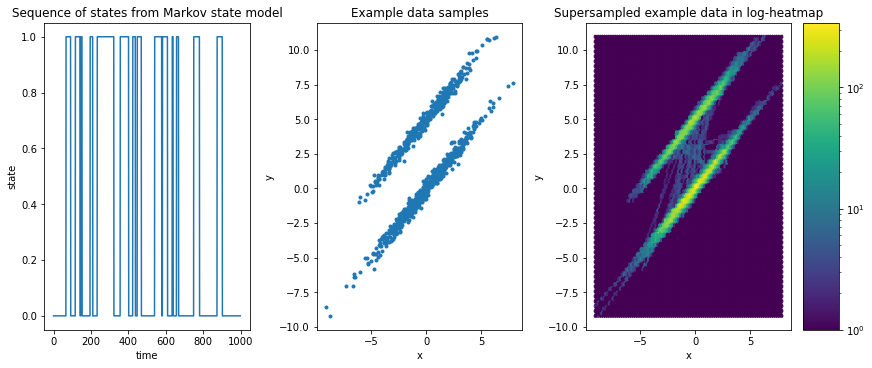

In [7]:
import matplotlib.pyplot as plt  # plotting
f, axes = plt.subplots(1, 3, figsize=(12, 5), constrained_layout=True)
ax1, ax2, ax3 = axes.flat

# discrete trajectory
ax1.plot(discrete_trajectory)
ax1.set_xlabel('time')
ax1.set_ylabel('state')
ax1.set_title('Sequence of states from Markov state model');

# scatter plot of samples
ax2.scatter(*(feature_trajectory.T), marker='.')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Example data samples')

# interpolate ftraj so that 50 times more steps are made and transitions become visible
# in heatmap representation
n_interp = 50
n_steps = len(discrete_trajectory)
xs = np.arange(n_steps, step=1./n_interp)
ftraj_interp = np.empty((n_steps*n_interp, 2))
ftraj_interp[:, 0] = np.interp(xs, np.arange(n_steps), feature_trajectory[:, 0])
ftraj_interp[:, 1] = np.interp(xs, np.arange(n_steps), feature_trajectory[:, 1])

# heatmap
hb = ax3.hexbin(ftraj_interp[:, 0], ftraj_interp[:, 1], bins='log')
f.colorbar(hb, ax=ax3)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('Supersampled example data in log-heatmap');

If we project back into one dimension with PCA, the result contains basically no signal: PCA finds the axis that maximizes variance, which is along long axis of the ellipsoids and completely ignores temporal information.

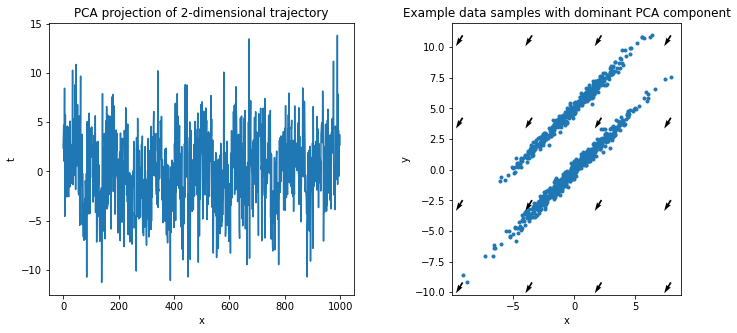

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1).fit(feature_trajectory)  # fit the 2-dimensional data

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
projection = pca.transform(feature_trajectory)
ax1.plot(projection)
ax1.set_title('PCA projection of 2-dimensional trajectory')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

dxy = pca.components_[0]  # dominant pca component

ax2.scatter(*(feature_trajectory.T), marker='.')
x, y = np.meshgrid(
    np.linspace(np.min(feature_trajectory[:, 0]), np.max(feature_trajectory[:, 0]), 4),
    np.linspace(np.min(feature_trajectory[:, 1]), np.max(feature_trajectory[:, 1]), 4)
)
plt.quiver(x,y,dxy[0],dxy[1])

ax2.set_aspect('equal')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Example data samples with dominant PCA component');

On the other hand, projecting with TICA takes temporal information into account and finds the dominant slow direction, i.e., the rare transition between the two distributions.

We create a TICA estimator, parameterized by the `lagtime`, which is the time shift $\tau$ for which autocorrelations are taken into account, and `dim`, which is the dimension. Here, the dimension can either be an `int` , a `float`, or `None` - each having significant influence on how the projection dimension is determined:

- in case `dim` is `None`, all available ranks are kept;
- in case `dim` is an integer (like in this case), it must be positive and fixes the projection dimension to the given value;
- in case `dim` is a floating point value (e.g., `TICA(..., dim=0.7)`), it must be `0 < dim <= 1`. Then, it selects the number of dimensions such that the amount of kinetic variance that needs to be explained is greater than the percentage specified by dim.

In [9]:
tica = deeptime.decomposition.TICA(
    dim=1,  # fix projection dimension explicitly
    lagtime=1
)

Now the [tica model](../api/generated/deeptime.decomposition.CovarianceKoopmanModel.rst#deeptime.decomposition.CovarianceKoopmanModel) can be estimated.

_Note_: In the reversible (default) case, this assumes that the data comes from an equilibirum distribution. Applying the method as-is to short off-equilibrium data produces heavily biased estimates. See [Koopman reweighting](#Koopman-reweighting) (or the corresponding [API docs](../api/generated/deeptime.covariance.KoopmanWeightingEstimator.rst#deeptime.covariance.KoopmanWeightingEstimator)) for a reweighting technique that extends TICA to non-equilibrium data.

In [10]:
tica_model = tica.fit(feature_trajectory, lagtime=1).fetch_model()  # fit and fetch model

We repeat the visualization of above and plot the projected data as well as the dominant slow direction, maximizing autocorrelation (instead of variance, cf PCA).

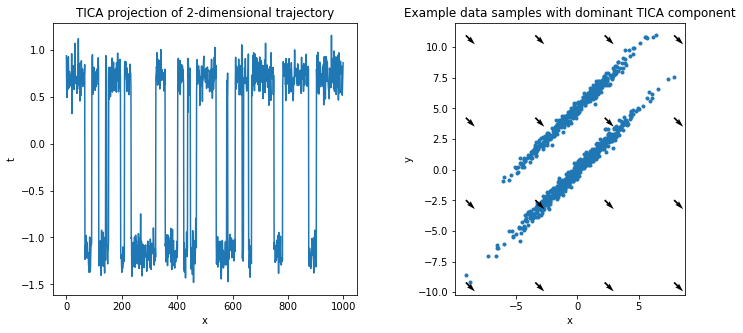

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(tica_model.transform(feature_trajectory))
ax1.set_title('TICA projection of 2-dimensional trajectory')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

dxy = tica_model.singular_vectors_left[:, 0]  # dominant tica component

ax2.scatter(*(feature_trajectory.T), marker='.')
x, y = np.meshgrid(
    np.linspace(np.min(feature_trajectory[:, 0]), np.max(feature_trajectory[:, 0]), 4),
    np.linspace(np.min(feature_trajectory[:, 1]), np.max(feature_trajectory[:, 1]), 4)
)
plt.quiver(x, y, dxy[0], dxy[1])

ax2.set_aspect('equal')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Example data samples with dominant TICA component');

The implied timescales of the tica model can be accessed as follows:

In [12]:
tica_model.timescales(lagtime=1)

array([12.65404138,  0.28430943])

In principle, one should expect as many timescales as
input coordinates were available. However, fewer eigenvalues will be returned if the TICA matrices
were not full rank or `dim` contained a floating point percentage, i.e., was interpreted as
variance cutoff.

The model also offers a function that yields an instantaneous correlation matrix between mean-free input features and TICs (i.e., the axes that are projected onto).

In [13]:
tica_model.feature_component_correlation

array([[ 0.02112484],
       [-0.6493549 ]])

In greater detail: Denoting the input features as $X_i$ and the TICs as $\theta_j$, the instantaneous, linear
correlation between them can be written as

$$  \mathbf{Corr}(X_i - \mu_i, \mathbf{\theta}_j) = \frac{1}{\sigma_{X_i - \mu_i}}\sum_l \sigma_{(X_i - \mu_i)(X_l - \mu_l)} \mathbf{U}_{li}. $$

The matrix $\mathbf{U}$ is the matrix containing the eigenvectors of the TICA generalized eigenvalue problem as column vectors, i.e., there is a row for each feature and a column for each TIC.

## Eigenvector scaling

The TICA estimator possesses a scaling parameter which can be used to introduce further properties to the projection. It can take the following values:

`None`: No scaling.

In [14]:
tica.scaling = None
tica_model = tica.fit(feature_trajectory, lagtime=1).fetch_model()

`"kinetic_map"` (default): Eigenvectors will be scaled by eigenvalues. As a result, Euclidean distances in the transformed data approximate kinetic distances <cite data-cite="nbtica-noe2015kinetic">(Noé, 2015)</cite>. This is a good choice when the data is further processed by clustering.

In [15]:
tica.scaling = "kinetic_map"  # default
tica_model_kinetic_map = tica.fit(feature_trajectory, lagtime=1).fetch_model()

`"commute_map"`: Eigenvector i will be scaled by $\sqrt{\mathrm{timescale}_i / 2}$. As a result, Euclidean distances in the transformed data will approximate commute distances <cite data-cite="nbtica-noe2016commute">(Noé, 2016)</cite>.

In [16]:
tica.scaling = "commute_map"
tica_model_commute_map = tica.fit(feature_trajectory, lagtime=1).fetch_model()

Visualizing the projections:

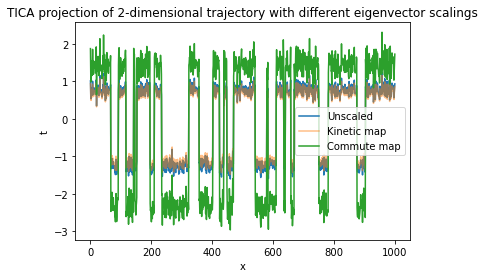

In [17]:
f, ax1 = plt.subplots(1, 1)
ax1.plot(tica_model.transform(feature_trajectory), label="Unscaled")
ax1.plot(tica_model_kinetic_map.transform(feature_trajectory), label="Kinetic map", alpha=.5)
ax1.plot(tica_model_commute_map.transform(feature_trajectory), label="Commute map")
ax1.set_title('TICA projection of 2-dimensional trajectory with different eigenvector scalings')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.legend();

## Koopman reweighting

If the data that is used for estimation (for the most part) is not in equilibrium, the estimate can become heavily biased in case reversibility is enforced. Koopman reweighting <cite data-cite="nbtica-wu2017variational">(Wu, 2017)</cite> assigns weights to each frame of the time series so that also off-equilibrium data can be used. In deeptime, a [Koopman weighting estimator](../api/generated/deeptime.covariance.KoopmanWeightingEstimator.rst#deeptime.covariance.KoopmanWeightingEstimator) is implemented, which learns appropriate weights from data. The corresponding [Koopman model](../api/generated/deeptime.covariance.KoopmanWeightingModel.rst#deeptime.covariance.KoopmanWeightingModel) can be used as an argument in TICA's `fit`.

This reweighting technique becomes necessary as soon as the available data is not a single long trajectory which equilibrates and then is in an equilibrium state for the rest of the time but rather if many short and at least initially off-equilibrium trajectories are used. 

In [18]:
tica = deeptime.decomposition.TICA(lagtime=1, dim=1)

Learning the weights

In [19]:
koopman_estimator = deeptime.covariance.KoopmanWeightingEstimator(lagtime=1)
reweighting_model = koopman_estimator.fit(feature_trajectory).fetch_model()

...and fitting TICA using said weights.

In [20]:
tica_model_reweighted = tica.fit(feature_trajectory, weights=reweighting_model) \
    .fetch_model()

Again the results can be visualized.

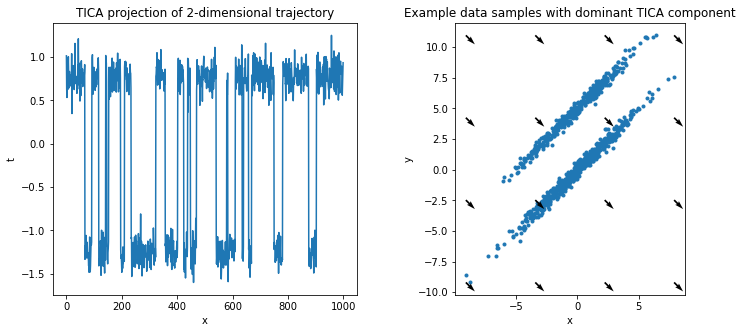

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(tica_model.transform(feature_trajectory))
ax1.set_title('TICA projection of 2-dimensional trajectory')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

dxy = tica_model.singular_vectors_left[:, 0]  # dominant tica component

ax2.scatter(*(feature_trajectory.T), marker='.')
x, y = np.meshgrid(
    np.linspace(np.min(feature_trajectory[:, 0]), np.max(feature_trajectory[:, 0]), 4),
    np.linspace(np.min(feature_trajectory[:, 1]), np.max(feature_trajectory[:, 1]), 4)
)
plt.quiver(x, y, dxy[0], dxy[1])

ax2.set_aspect('equal')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Example data samples with dominant TICA component');